In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
from src.grid import *
from src import pml, pec_pmc
from eigenwell.src.constants import *

In [2]:
## why does assymeetry mess up our system?

In [3]:
N = np.array([100,240])
# plt.figure(figsize = (10,10))
# plt.spy(fd.Dyb, markersize = 2)
L = np.array([1e-6, 1e-6]);
dL= L/N
print(L)
xrange = [-L[0]/2, L[0]/2]
yrange = [-L[1]/2, L[1]/2]

x = np.linspace(xrange[0], xrange[1], N[0])
y = np.linspace(yrange[0], yrange[1], N[1])

X,Y = np.meshgrid(x,y, indexing = 'ij');
print(dL)

[1.e-06 1.e-06]
[1.00000000e-08 4.16666667e-09]


## PML test
Best way to test pml is FDFD driven

[100 240]
[-5e-07, 5e-07] [-5e-07, 5e-07]
[1.00000000e-08 4.16666667e-09] [100 240] [1.e-06 1.e-06]
(24000, 24000) (24000,)


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


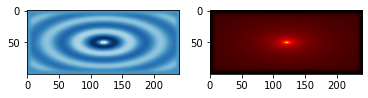

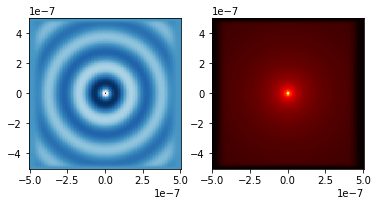

In [8]:
from scipy.sparse.linalg import spsolve as bslash
eps_r = np.ones(N)
wvlen = 0.2e-6;
Mz = np.zeros(N)

Npml = [15,15]
print(N)
Mz[N[0]//2,N[1]//2] = 1;

M = np.prod(N)
b = np.reshape(Mz, (M,), order = 'F'); #(Mz.flatten());

omega = 2*np.pi*C0/wvlen;

pml_obj = pml.PML(N,Npml, omega);
#self.Sxf, self.Syf, self.Sxb, self.Syb
Sxf, Syf, Sxb, Syb = pml_obj.Soperators(xrange, yrange);
print(xrange, yrange)


print(dL,N, dL*N)
fd = FiniteDifferenceGrid(dL,N)
fd.make_derivatives()

Tep = sp.spdiags(eps_r.flatten(), 0, np.prod(N), np.prod(N))

A = (Sxf@fd.Dxf)@(Sxb@fd.Dxb) + (Syf@fd.Dyf)@(Syb@fd.Dyb) + omega**2*MU0*EPSILON0*Tep;
print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.subplot(121)
plt.imshow(np.real(field), cmap = 'RdBu')
plt.subplot(122)
plt.imshow(np.abs(field), cmap = 'hot')
plt.show();

ax = plt.subplot(121)
plt.pcolormesh(X,Y, np.real(field), cmap = 'RdBu', shading = 'auto')
ax.set_aspect('equal')
ax = plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(field), cmap = 'hot',shading = 'auto')
ax.set_aspect('equal')

plt.show();


(24000, 24000)


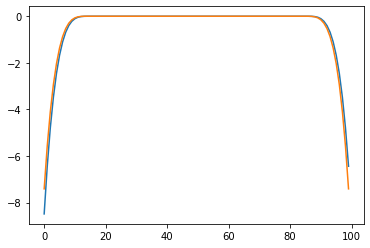

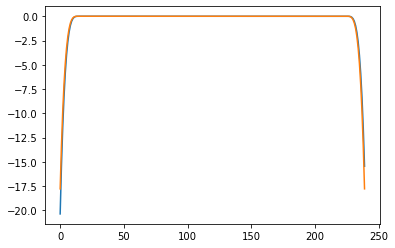

In [9]:
print(pml_obj.Sxf.shape)
plt.plot(np.imag(pml_obj.sxb))
plt.plot(np.imag(pml_obj.sxf))
plt.show();
plt.plot(np.imag(pml_obj.syb))
plt.plot(np.imag(pml_obj.syf))


## Symmetrization of PML

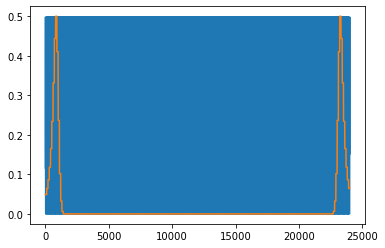

(24000, 24000)
  (0, 0)	(618304918753918.9-111115116179768.16j)
  (0, 1)	(-172657463653465.75+47738769151140.25j)
  (1, 2)	(-293171078657307.5+109550860390557.84j)
  (1, 1)	(768284618829215.4-179870308058668.3j)
  (1, 0)	(-172657463653465.7+47738769151140.234j)
  (2, 3)	(-499681210979708.5+261767271431457.62j)
  (2, 2)	(1088031554223333-377486234388645.94j)
  (2, 1)	(-293171078657307.5+109550860390557.83j)
  (3, 4)	(-822028929697815.1+640727792333203.9j)
  (3, 3)	(1616532030797075.8-869153467384144.5j)
  (3, 2)	(-499681210979708.56+261767271431457.7j)
  (4, 4)	(2339788476927402.5-2072769861343362j)
  (4, 3)	(-822028929697815+640727792333204j)

  (0, 1)	(-172657463653465.75+47738769151140.25j)
  (0, 0)	(303044338077621.9-77825123731936.27j)
  (1, 1)	(453024038152918.5-146580315610836.44j)
  (1, 0)	(-172657463653465.72+47738769151140.24j)
  (1, 2)	(-293171078657307.5+109550860390557.83j)
  (2, 2)	(772770973547035.9-344196241940814j)
  (2, 1)	(-293171078657307.44+109550860390557.84j)
  (2

In [67]:

A = (Sxb@fd.Dxb)@(Sxf@fd.Dxf) + (Syb@fd.Dyb) @(Syf@fd.Dyf)



sxb =  pml_obj.Sxb.diagonal();
syb = pml_obj.Syb.diagonal();

sxf =  pml_obj.Sxf.diagonal();
syf = pml_obj.Syf.diagonal();
## T

plt.plot(np.imag(sxb))
plt.plot(np.imag(syb))
plt.show();
 
M = np.prod(N)
numerator = np.sqrt(sxb*syb);
denominator = 1/(numerator);
Pr1 = sp.spdiags(numerator, 0, M,M);
Pl1 = sp.spdiags(denominator,0,M,M);

numerator = np.sqrt(sxf*syf);
denominator = 1/(numerator);
Pr2 = sp.spdiags(numerator, 0, M,M);
Pl2 = sp.spdiags(denominator,0,M,M);

print(Pr1.shape);

symA = Pl1@(A@Pr1)

#Pl^-1*(A*Pr^-1);
print(symA[0:5, 0:5])

print()
symSubX = Pl1@(Sxb@fd.Dxb)@(Sxf@fd.Dxf)@Pr1
symSubY = Pl2@(Syb@fd.Dyb)@(Syf@fd.Dyf) @Pr2

print(symSubX[0:5, 0:5])

## eigenvalue solve with eigsh
import time;
t0 = time.time()
#eigenvals, eigenvecs = sp.linalg.eigsh(symA)
eigenvals, eigenvecs = sp.linalg.eigs(symA)

t1 = time.time();
print('time: ',t1-t0)

[100 240]


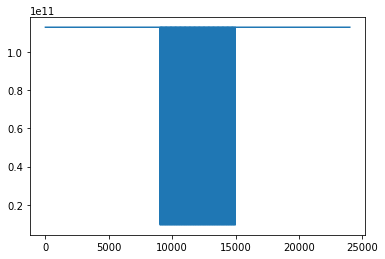

  (0, 0)	(-6.408252194565825e+31+1.2491713295597634e+31j)
  (0, 1)	(2.0186134389569632e+31-6.464163833052953e+30j)
  (1, 1)	(-8.593903769603343e+31+2.3840916718751452e+31j)
  (1, 2)	(3.443878720519621e+31-1.515255917266853e+31j)
  (1, 0)	(2.0186134389569632e+31-6.464163833052954e+30j)
  (2, 2)	(-1.2330561576673435e+32+5.181795345253038e+31j)
  (2, 3)	(5.810016810486231e+31-3.676493655655226e+31j)
  (2, 1)	(3.4438787205196203e+31-1.5152559172668528e+31j)
  (3, 3)	(-1.811693541344103e+32+1.2138997072252521e+32j)
  (3, 4)	(9.095846272117706e+31-8.984283939574676e+31j)
  (3, 2)	(5.81001681048623e+31-3.676493655655227e+31j)
  (4, 4)	(-2.4275192685836946e+32+2.852516864187816e+32j)
  (4, 3)	(9.095846272117706e+31-8.984283939574672e+31j)
0

  (0, 1)	9.265577079357959e-20
  (0, 99)	5.559346247614775e-19
  (0, 23900)	1.9791281317140665e-19
  (1, 0)	9.265577079357959e-20
  (1, 2)	7.64059059609897e-19
  (1, 101)	7.412461663486367e-19
  (1, 23901)	1.8531154158715917e-19
  (2, 1)	7.64059059609897e-

In [54]:
#### test TM polarization
eps_r = np.ones(N)
print(N)
eps_r[40:60,90:150] = 12;

# invTepxx = sp.identity(M)
# invTepyy = sp.identity(M)
invTepxx = sp.spdiags(1/(EPSILON0*eps_r.flatten(order = 'F')), 0, M,M)
invTepyy = sp.spdiags(1/(EPSILON0*eps_r.flatten(order = 'F')), 0, M,M)

plt.plot(invTepxx.diagonal())
plt.show();

# ATM = -(1/MU0)* ( Sxb@fd.Dxb@(invTepxx)@Sxf@fd.Dxf + Syb@fd.Dyb@(invTepyy)@Syf@fd.Dyf )
ATM = -(1/MU0)* ( Sxf@fd.Dxf@(invTepxx)@Sxb@fd.Dxb + Syf@fd.Dyf@(invTepyy)@Syb@fd.Dyb )

ATM_sym= Pl2@ATM@Pr2;

print(ATM_sym[0:5, 0:5])

print(((abs(ATM_sym-ATM_sym.T)/np.max(np.abs(ATM_sym)))>1e-10).nnz)
diff = (abs(ATM_sym-ATM_sym.T)/np.max(np.abs(ATM_sym)));
print()
print(diff)

## PEC_PMC


(24000, 24000) (24000,)


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


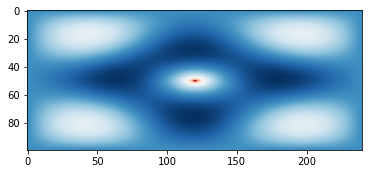

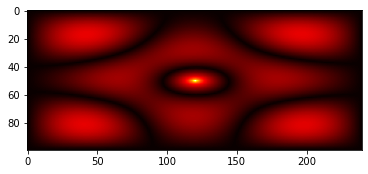

[[  0   1   2 ... 237 238 239]
 [  0   1   2 ... 237 238 239]
 [  0   1   2 ... 237 238 239]
 ...
 [  0   1   2 ... 237 238 239]
 [  0   1   2 ... 237 238 239]
 [  0   1   2 ... 237 238 239]]


In [34]:
pec_pmc_obj = pec_pmc.PEC_PMC(N)
mx= pec_pmc_obj.mask_x;
my = pec_pmc_obj.mask_y;
wvlen = 0.5e-6;
omega = 2*np.pi*C0/wvlen;


fd = FiniteDifferenceGrid(dL,N)

A = mx@my@((fd.Dxf)@(fd.Dxb) + (fd.Dyf)@(fd.Dyb))@my@mx + omega**2*MU0*EPSILON0*Tep;

print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.imshow(np.real(field), cmap = 'RdBu')
plt.show();

plt.imshow(np.abs(field), cmap = 'hot')
plt.show();


#plt.imshow(pec_pmc_obj.mask_y.diagonal().reshape(N, order = 'F'))

xn = list(range(N[0]));
yn = list(range(N[1]));

## ordering should be 'F' contiguous
[Xn,Yn] = np.meshgrid(xn,yn, indexing = 'ij');

print(Yn)

(24000, 24000) (24000,)


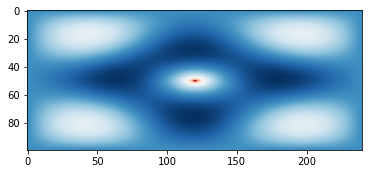

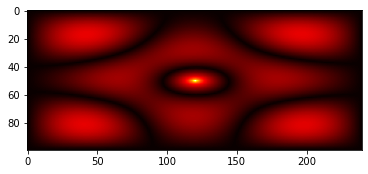

In [35]:
def grid_average(center_array, w):
    '''
        sdf;
    '''
    # computes values at cell edges

    xy = {'x': 0, 'y': 1}
    center_shifted = np.roll(center_array, 1, axis=xy[w])
    avg_array = (center_shifted+center_array)/2
    return avg_array


mx= pec_pmc_obj.mask_x;
my = pec_pmc_obj.mask_y;
wvlen = 0.5e-6;
omega = 2*np.pi*C0/wvlen;

epxx = grid_average(eps_r,'x')
epyy = grid_average(eps_r, 'y')

invTepxx = sp.spdiags(1/epxx.flatten(),0,M,M);
invTepyy = sp.spdiags(1/epyy.flatten(),0,M,M);

fd = FiniteDifferenceGrid(dL,N)
I = sp.identity(M)
A = (mx@fd.Dxf)@(invTepxx)@(fd.Dxb@mx) + (my@fd.Dyf)@(invTepyy)@(fd.Dyb@my) + omega**2*MU0*EPSILON0*I;

print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.imshow(np.real(field), cmap = 'RdBu')
plt.show();

plt.imshow(np.abs(field), cmap = 'hot')
plt.show();

## Assymetric Structures, assymetric PML

like a waveguide or a plane wave

[100 240]
[-5e-07, 5e-07] [-5e-07, 5e-07]
[1.00000000e-08 4.16666667e-09] [100 240] [1.e-06 1.e-06]
(24000, 24000) (24000,)


../src/pml.py:41: RuntimeWarning: divide by zero encountered in true_divide
  sigma_max = self.sigma_max / d_pml; #usually the pml is the same thickness on both sides


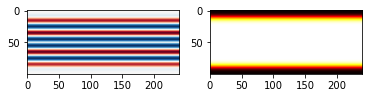

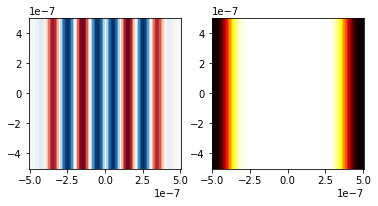

In [36]:
from scipy.sparse.linalg import spsolve as bslash
eps_r = np.ones(N)
wvlen = 0.2e-6;
Mz = np.zeros(N)

Npml = [30,0]
print(N)
#Mz[:,N[1]//2] = 1;
Mz[N[0]//2,:] = 1;

M = np.prod(N)
b = np.reshape(Mz, (M,), order = 'F'); #(Mz.flatten());

omega = 2*np.pi*C0/wvlen;

pml_obj = pml.PML(N,Npml, omega);
#self.Sxf, self.Syf, self.Sxb, self.Syb
Sxf, Syf, Sxb, Syb = pml_obj.Soperators(xrange, yrange);
print(xrange, yrange)


print(dL,N, dL*N)
fd = FiniteDifferenceGrid(dL,N)
fd.make_derivatives()

Tep = sp.spdiags(eps_r.flatten(), 0, np.prod(N), np.prod(N))

A = (Sxf@fd.Dxf)@(Sxb@fd.Dxb) + (Syf@fd.Dyf)@(Syb@fd.Dyb) + omega**2*MU0*EPSILON0*Tep;
print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.subplot(121)
plt.imshow(np.real(field), cmap = 'RdBu')
plt.subplot(122)
plt.imshow(np.abs(field), cmap = 'hot')
plt.show();

ax = plt.subplot(121)
plt.pcolormesh(X,Y, np.real(field), cmap = 'RdBu', shading = 'auto')
ax.set_aspect('equal')
ax = plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(field), cmap = 'hot',shading = 'auto')
ax.set_aspect('equal')

plt.show();
